In [1]:
import torch
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pathlib import Path
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns

In [2]:
def GenMonthList(start_month, end_month):
    months = []
    current = datetime.datetime.strptime(str(start_month)+'1', '%Y%m%d').date()
    end_month = datetime.datetime.strptime(str(end_month)+'1', '%Y%m%d').date()

    while current <= end_month:
        months.append(current.strftime('%Y%m'))
        current += relativedelta(months=1)

    return [int(x) for x in months]

def rmse_func(y_pred, y_true, mask):
    y_pred = torch.from_numpy(y_pred)
    y_true = torch.from_numpy(y_true)
    mask = torch.from_numpy(mask)
    rmse = torch.sum((y_pred - y_true)**2*mask, dim=[1, 2]) / mask.sum(dim=[1, 2])
    rmse = rmse.sqrt()
    return rmse

def mae_func(y_pred, y_true, mask):
    y_pred = torch.from_numpy(y_pred)
    y_true = torch.from_numpy(y_true)
    mask = torch.from_numpy(mask)
    mae = torch.abs(y_pred - y_true) * mask
    mae = mae.sum(dim=[1, 2]) / mask.sum(dim=[1, 2])
    return mae

def acc_func(y_pred, y_true, mask):
    y_pred = torch.from_numpy(y_pred)
    y_true = torch.from_numpy(y_true)
    mask = torch.from_numpy(mask)
    mask = torch.all(mask, dim=0)

    pred = y_pred - y_pred.mean(dim=0, keepdim=True)  # (N, *)
    true = y_true - y_true.mean(dim=0, keepdim=True)  # (N, *)
    ExEy = (pred * true).mean(dim=0)
    Exy = torch.mean(pred**2, dim=0) * torch.mean(true**2, dim=0)
    cor = (ExEy + 1e-6) / (Exy.sqrt() + 1e-6)
    cor = (cor * mask).sum() / mask.sum()
    return cor

def acc_func_detrend(y_pred, y_true, mask):
    y_pred = torch.from_numpy(y_pred)
    y_true = torch.from_numpy(y_true)
    mask = torch.from_numpy(mask)
    mask = torch.all(mask, dim=0)
    
    y_pred = y_pred - clim_alltime[-24:]
    y_true = y_true - clim_alltime[-24:]

    pred = y_pred - y_pred.mean(dim=0, keepdim=True)  # (N, *)
    true = y_true - y_true.mean(dim=0, keepdim=True)  # (N, *)
    ExEy = (pred * true).mean(dim=0)
    Exy = torch.mean(pred**2, dim=0) * torch.mean(true**2, dim=0)
    cor = (ExEy + 1e-6) / (Exy.sqrt() + 1e-6)
    out = cor
    cor = (cor * mask).sum() / mask.sum()
    return cor, out

def acf_func(seq, lag=1):
    seqmean = seq.mean(axis=0, keepdims=True)
    seq1 = seq[:-lag] - seqmean
    seq2 = seq[lag:] - seqmean
    C0 = seq - seqmean
    C0 = np.mean(C0**2, axis=0)
    acf = ((seq1 * seq2).sum(axis=0) / seq.shape[0] + 1e-6) / (C0 + 1e-6)
    return acf

In [3]:
# change the corresponding paths to your local paths
train_masks = np.load('SIC_prediction/trained_models/one_step/convlstm/test_result/train_masks.npy')
targets = np.load('SIC_prediction/trained_models/one_step/convlstm/test_result/targets.npy')
months = np.load('SIC_prediction/trained_models/one_step/convlstm/test_result/months.npy')
sic_pred_convlstm = np.load('SIC_prediction/trained_models/one_step/convlstm/test_result/sic_pred.npy')
sic_pred_lstm = np.load('SIC_prediction/trained_models/one_step/convlstm_kernel1/test_result/sic_pred.npy')
sic_pred_convlstm[targets==-0.1] = -0.1

In [4]:
train_masks = train_masks[:, 0, 0]
targets = targets[:, 0, 0]
sic_pred_convlstm = sic_pred_convlstm[:, 0, 0]
sic_pred_lstm = sic_pred_lstm[:, 0, 0]

In [5]:
sic_pred_convlstm.shape, sic_pred_lstm.shape, train_masks.shape, targets.shape, months.shape

((24, 448, 304), (24, 448, 304), (24, 448, 304), (24, 448, 304), (24, 14))

In [6]:
data = xr.open_dataset('data/full_sic.nc')

In [7]:
c = data.sel(time=GenMonthList(*(198001, 201812)))
c['time'] = c.time.values%100  # to calculate the climatology later

In [8]:
clim = c.imgs.groupby('time').mean('time')
clim_alltime = clim.values[None].repeat(repeats=c.imgs.shape[0]/12, axis=0).reshape(-1, 448, 304)

In [9]:
# anomaly persistence
input_start_time = 201812
input_end_time = 202011
pred_start_time = 201901
pred_end_time = 202012
input_times = GenMonthList(input_start_time, input_end_time)
pred_times = GenMonthList(pred_start_time, pred_end_time)
input_months = [x%100 for x in input_times]
pred_months = [x%100 for x in pred_times]
sic_pred = [None] * len(pred_months)
for i in range(len(input_months)):
    anomaly = data.imgs.sel(time=input_times[i]).values - clim.sel(time=input_months[i]).values
    sic_pred[i] = clim.sel(time=pred_months[i]) + anomaly
sic_pred_anomaly_persistence = np.array(sic_pred)
land = sic_pred_anomaly_persistence == -0.1
sic_pred_anomaly_persistence = np.clip(sic_pred_anomaly_persistence, 0, 1)
sic_pred_anomaly_persistence[land] = -0.1

In [10]:
# damped anomaly persistence
sic_pred_dap = [None] * len(pred_months)
acf = acf_func(c.imgs.values - clim_alltime)
for i in range(len(input_months)):
    anomaly = data.imgs.sel(time=input_times[i]).values - clim.sel(time=input_months[i]).values
    sic_pred_dap[i] = clim.sel(time=pred_months[i]) + anomaly*acf
sic_pred_dap = np.array(sic_pred_dap)
land = sic_pred_dap == -0.1
sic_pred_dap = np.clip(sic_pred_dap, 0, 1)
sic_pred_dap[land] = -0.1

In [11]:
# anomaly persistence
rmse_ap = rmse_func(sic_pred_anomaly_persistence, targets, train_masks)
mae_ap = mae_func(sic_pred_anomaly_persistence, targets, train_masks)
acc_ap = acc_func(sic_pred_anomaly_persistence, targets, train_masks)
acc_detrend_ap, acc_map_ap = acc_func_detrend(sic_pred_anomaly_persistence, targets, train_masks)
rmse_ap.mean(), mae_ap.mean(), acc_ap, acc_detrend_ap

(tensor(0.0948, dtype=torch.float64),
 tensor(0.0399, dtype=torch.float64),
 tensor(0.8766, dtype=torch.float64),
 tensor(0.6382, dtype=torch.float64))

In [12]:
# damped anomaly persistence
rmse_dap = rmse_func(sic_pred_dap, targets, train_masks)
mae_dap = mae_func(sic_pred_dap, targets, train_masks)
acc_dap = acc_func(sic_pred_dap, targets, train_masks)
acc_detrend_dap, acc_map_dap = acc_func_detrend(sic_pred_dap, targets, train_masks)
rmse_dap.mean(), mae_dap.mean(), acc_dap, acc_detrend_dap

(tensor(0.0917, dtype=torch.float64),
 tensor(0.0390, dtype=torch.float64),
 tensor(0.8990, dtype=torch.float64),
 tensor(0.6349, dtype=torch.float64))

In [13]:
# lstm
rmse_lstm = rmse_func(sic_pred_lstm, targets, train_masks)
mae_lstm = mae_func(sic_pred_lstm, targets, train_masks)
acc_lstm = acc_func(sic_pred_lstm, targets, train_masks)
acc_detrend_lstm, acc_map_lstm = acc_func_detrend(sic_pred_lstm, targets, train_masks)
rmse_lstm.mean(), mae_lstm.mean(), acc_lstm, acc_detrend_lstm

(tensor(0.0846, dtype=torch.float64),
 tensor(0.0344, dtype=torch.float64),
 tensor(0.8952, dtype=torch.float64),
 tensor(0.6910, dtype=torch.float64))

In [14]:
# convlstm
rmse_convlstm = rmse_func(sic_pred_convlstm, targets, train_masks)
mae_convlstm = mae_func(sic_pred_convlstm, targets, train_masks)
acc_convlstm = acc_func(sic_pred_convlstm, targets, train_masks)
acc_detrend_convlstm, acc_map_convlstm = acc_func_detrend(sic_pred_convlstm, targets, train_masks)
rmse_convlstm.mean(), mae_convlstm.mean(), acc_convlstm, acc_detrend_convlstm

(tensor(0.0704, dtype=torch.float64),
 tensor(0.0278, dtype=torch.float64),
 tensor(0.9203, dtype=torch.float64),
 tensor(0.7618, dtype=torch.float64))

Text(0.5, 1.0, 'RMSE for different models on the test set (2019-2020)')

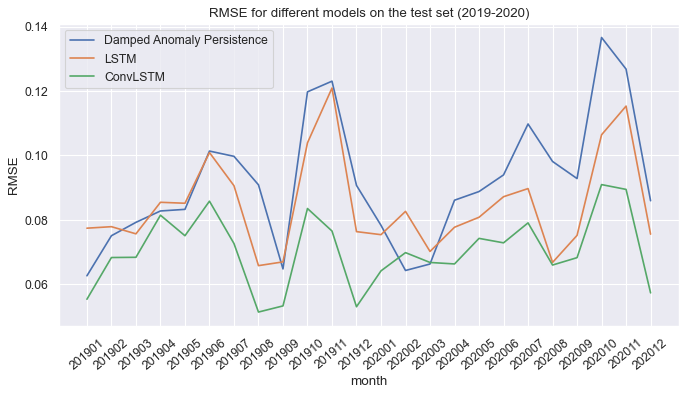

In [15]:
# plot the RMSE
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=80)
fig.patch.set_alpha(0)
#plt.plot(rmse_ap, label='anomaly persistence')
plt.plot(rmse_dap, label='Damped Anomaly Persistence')
plt.plot(rmse_lstm, label='LSTM')
plt.plot(rmse_convlstm, label='ConvLSTM')
plt.legend()
plt.xticks(ticks=range(24), labels=pred_times, rotation=40)
plt.xlabel('month')
plt.ylabel('RMSE')
plt.title('RMSE for different models on the test set (2019-2020)')
#plt.savefig('figures/RMSE.png')

Text(0.5, 1.0, 'MAE for different models on the test set (2019-2020)')

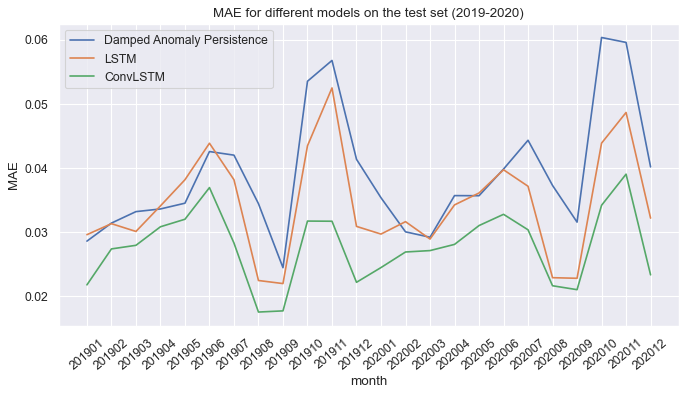

In [16]:
# plot the MAE
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=80)
fig.patch.set_alpha(0)
plt.plot(mae_dap, label='Damped Anomaly Persistence')
plt.plot(mae_lstm, label='LSTM')
plt.plot(mae_convlstm, label='ConvLSTM')
plt.legend()
plt.xticks(ticks=range(24), labels=pred_times, rotation=40)
plt.xlabel('month')
plt.ylabel('MAE')
plt.title('MAE for different models on the test set (2019-2020)')
#plt.savefig('figures/MAE.png')

In [17]:
# plot results of different models
black = ListedColormap(['Black'])
white = ListedColormap(['White'])
white = np.array(white(0))[None]
black = np.repeat(np.array(black(0))[None], 12, axis=0)
blues = plt.cm.get_cmap('Blues', 60)(np.linspace(0, 1, 60))[::-1]
reds = plt.cm.get_cmap('Reds', 60)(np.linspace(0, 1, 60))
cmap_diff = np.vstack((black, blues, white, reds))
cmap_diff = ListedColormap(cmap_diff)


def plot_diff(diff, model):
    copy = diff.copy()
    arr = xr.DataArray(copy[:, ::-1], dims=['month', 'x', 'y'], coords={'month': months[:, -1]})
    arr.plot(col='month', col_wrap=6, cmap=cmap_diff, vmin=-1.2, vmax=1)
    plt.suptitle(f'model = {model}', x=0.42, y=1.01)

In [18]:
diff_dap = sic_pred_dap - targets
diff_lstm = sic_pred_lstm - targets
diff_convlstm = sic_pred_convlstm - targets
land = (targets == -0.1)
diff_dap[land] = -1.2
diff_lstm[land] = -1.2
diff_convlstm[land] = -1.2

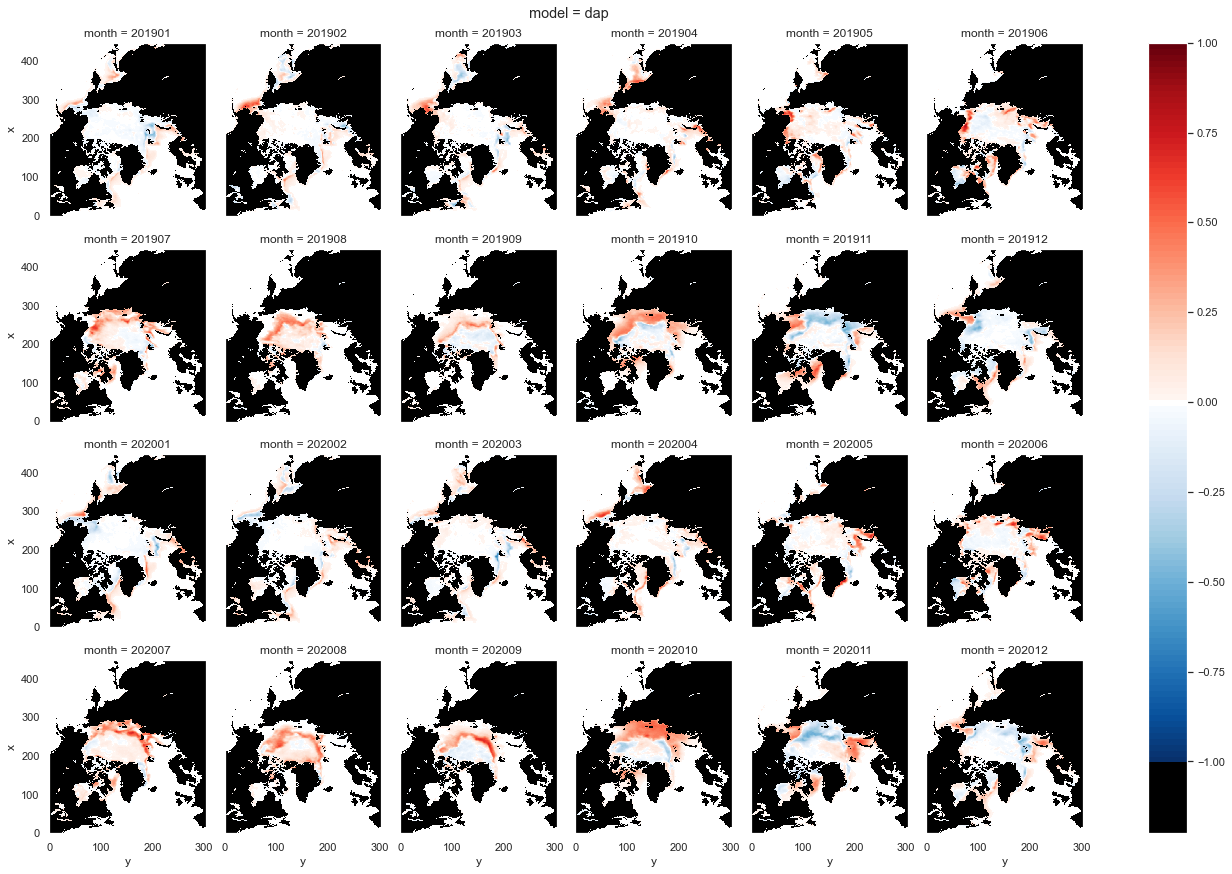

In [19]:
plot_diff(diff_dap, 'dap')

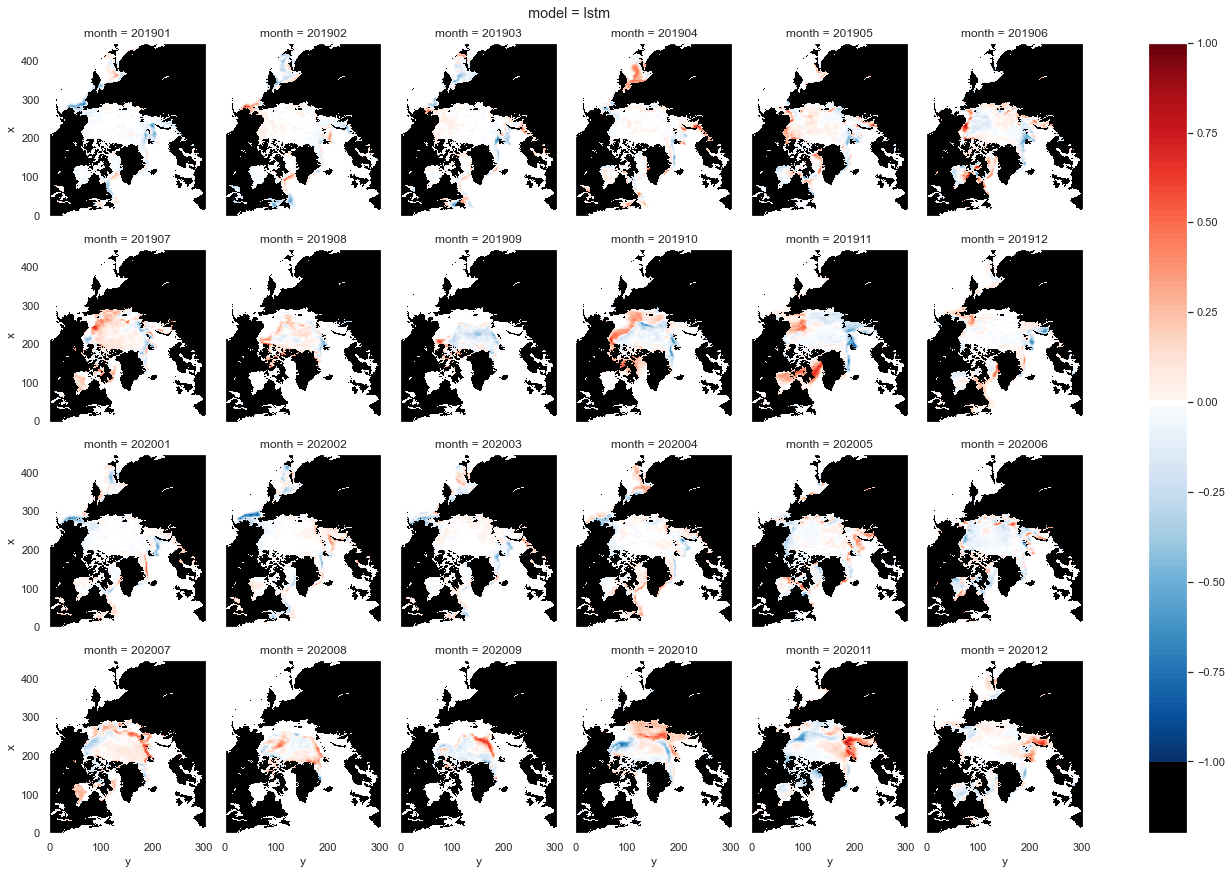

In [20]:
plot_diff(diff_lstm, 'lstm')

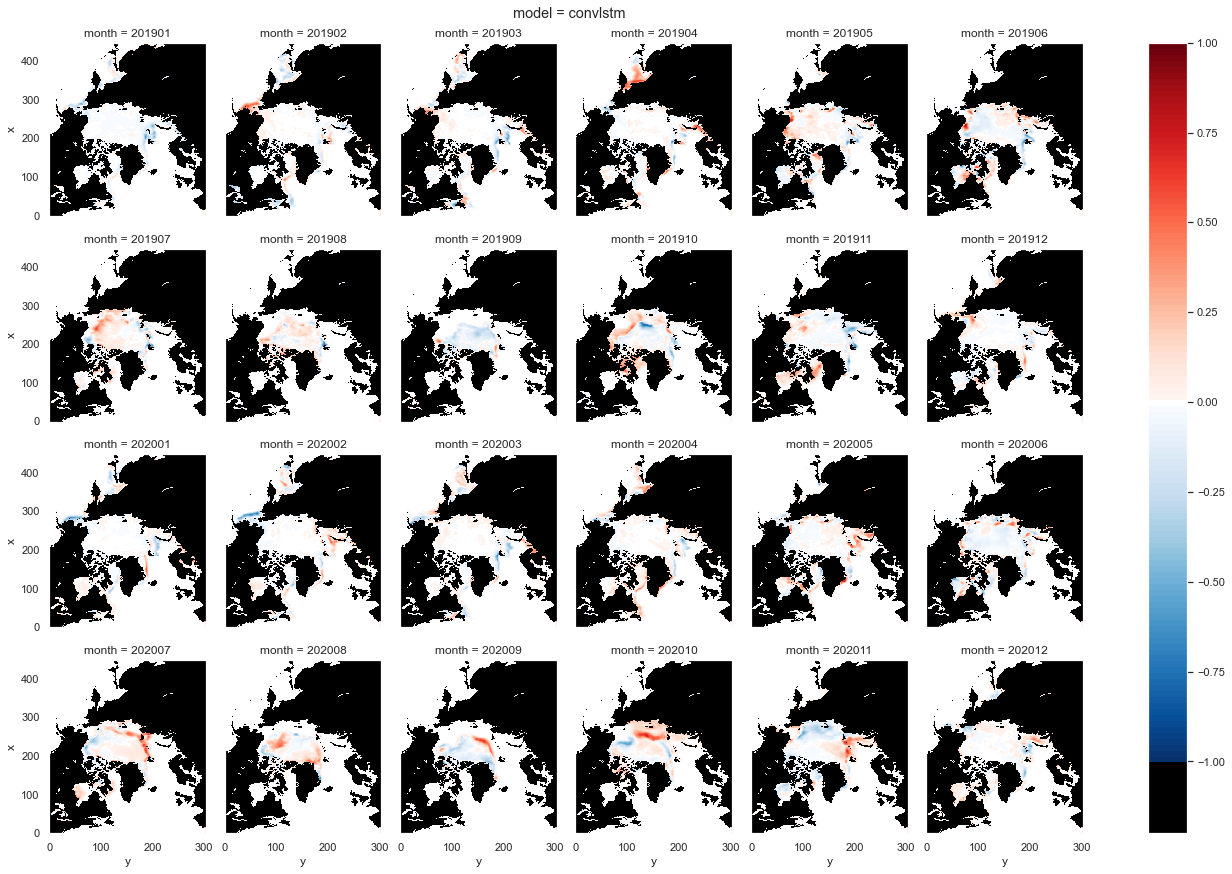

In [21]:
plot_diff(diff_convlstm, 'convlstm')

In [22]:
# plot the target sic
black = ListedColormap(['Black'])
black = np.repeat(np.array(black(0))[None], 12, axis=0)
blues = plt.cm.get_cmap('Blues', 120)(np.linspace(0, 1, 120))[::-1]
cmap = np.vstack((black, blues))
cmap = ListedColormap(cmap)


def plot_sic(sic, cmap):
    arr = xr.DataArray(sic[:, ::-1], dims=['month', 'x', 'y'], coords={'month': months[:, -1]})
    arr.plot(col='month', col_wrap=6, cmap=cmap, vmin=-0.1, vmax=1)
    #plt.savefig('figures/targets.png', transparent=True, bbox_inches='tight')

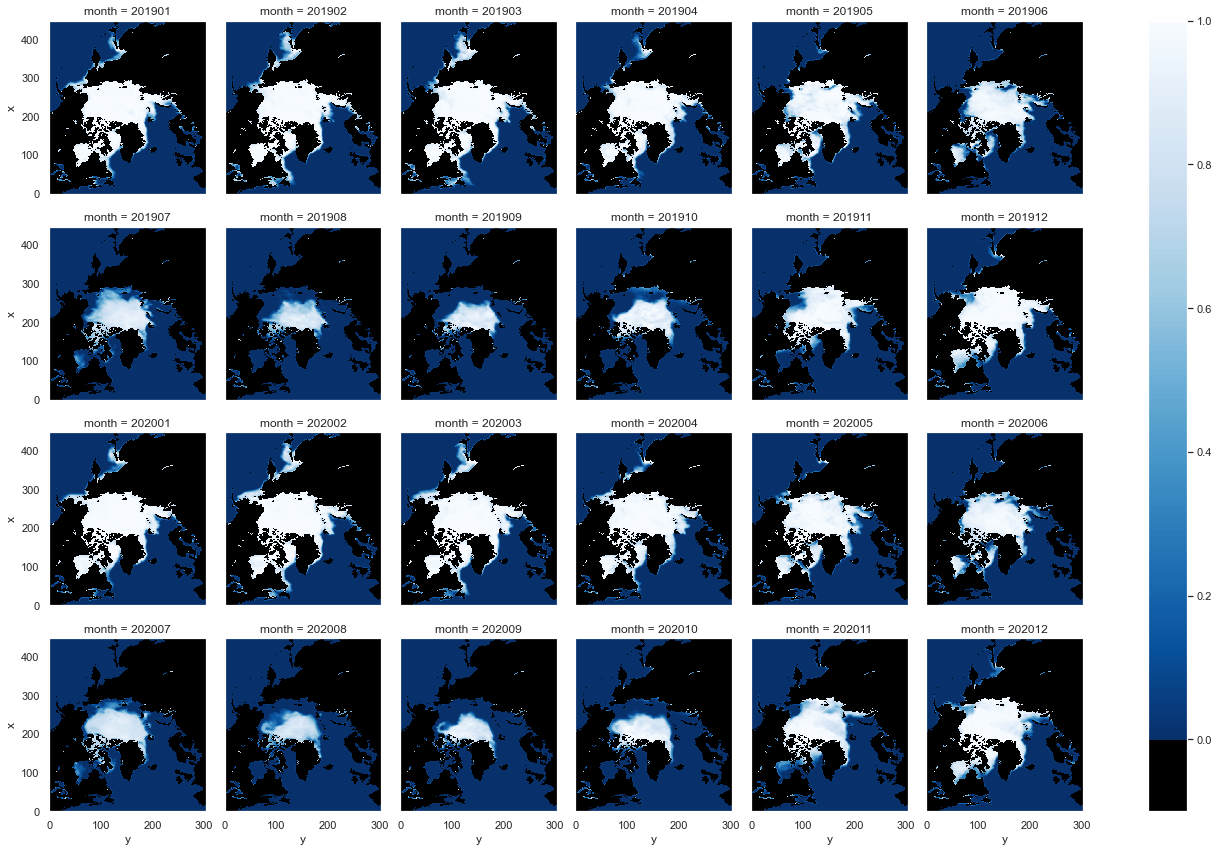

In [23]:
plot_sic(targets, cmap)

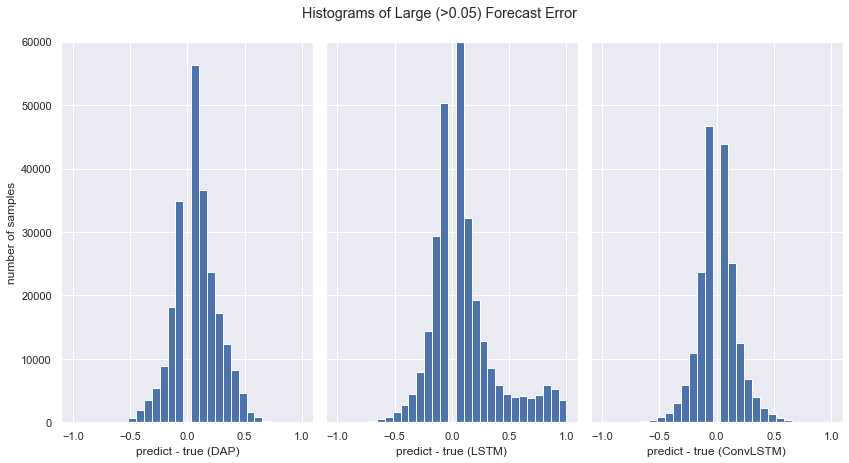

In [24]:
# plot the histogram of large error for different models
sns.set_theme()
ths = 0.05
d_dap = sic_pred_dap - targets
d_lstm = sic_pred_lstm - targets
d_convlstm = sic_pred_convlstm - targets
d_dap = d_dap[np.abs(d_dap)>ths]
d_lstm = d_lstm[np.abs(d_lstm)>ths]
d_convlstm = d_convlstm[np.abs(d_convlstm)>ths]
ymax = 60000
bins = np.linspace(-1, 1, 30)
fig, ax = plt.subplots(1, 3, figsize=(14, 7))
fig.patch.set_alpha(0)
plt.suptitle(f'Histograms of Large (>0.05) Forecast Error', y=0.95)
ax[0].hist(d_dap, bins=bins)
ax[0].set_ylim(0, ymax)
ax[0].set_xlabel('predict - true (DAP)')
ax[0].set_ylabel('number of samples')
ax[1].hist(d_lstm, bins=bins)
ax[1].set_ylim(0, ymax)
ax[1].axes.yaxis.set_ticklabels([])
ax[1].set_xlabel('predict - true (LSTM)')
ax[2].hist(d_convlstm, bins=bins)
ax[2].set_ylim(0, ymax)
ax[2].set_xlabel('predict - true (ConvLSTM)')
ax[2].axes.yaxis.set_ticklabels([])
plt.subplots_adjust(wspace=0.05)
#plt.savefig('figures/histogram.png')